# IST718 BIG DATA ANALYTICS
# Final Project Code

### Group members
- **David Forteguerre** <dfortegu@syr.edu>
- **Ziwei Pi** <zpi101@syr.edu>
- **Haoxuan Shi** <hshi10@syr.edu>

### Requirements
- PySpark (pyspark.sql, pyspark.ml)
- Numpy
- Pandas
- Matplotlib
- datetime

### Dataset
- The dataset can be downloaded at https://www.kaggle.com/kemical/kickstarter-projects
- The file imported should be the most recent one, i.e. ks-projects-201801.csv (the second file)

In [1]:
# to import relevant packages
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# to create spark and sparkcontext objects
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

# Data importation

In [2]:
# to read dataset into Spark
kickstarter_df = spark.read.format('csv').options(header='true', inferSchema='true').option("mode", "DROPMALFORMED").load('ks-projects-201801.csv') # this will read the data correctly and drop a few corrupted rows

# to view structure of the dataset 
kickstarter_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: string (nullable = true)
 |-- goal: string (nullable = true)
 |-- launched: string (nullable = true)
 |-- pledged: string (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: string (nullable = true)
 |-- country: string (nullable = true)
 |-- usd pledged: string (nullable = true)
 |-- usd_pledged_real: string (nullable = true)
 |-- usd_goal_real: string (nullable = true)



# I. Data exploration and cleansing

In [4]:
# to preview first 5 records
kickstarter_df.limit(5).toPandas()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00


In [5]:
# to view number of columns
columns = len(kickstarter_df.columns)
print('columns:', columns)

# to view number of rows
rows = kickstarter_df.count()
print('rows:', rows)

columns: 15
rows: 377364


In [6]:
# to learn more about the variables
from pyspark.sql.functions import col, countDistinct

# to look at counts for categorical  variables 
kickstarter_df.agg(countDistinct(col("name")).alias("name"),
                   countDistinct(col("category")).alias("category"),
                   countDistinct(col("main_category")).alias("main_category"),
                   countDistinct(col("currency")).alias("currency"),
                   countDistinct(col("state")).alias("state"),
                   countDistinct(col("country")).alias("country"),
                  ).show()

+------+--------+-------------+--------+-----+-------+
|  name|category|main_category|currency|state|country|
+------+--------+-------------+--------+-----+-------+
|374467|     159|           15|      14|    6|     23|
+------+--------+-------------+--------+-----+-------+



In [7]:
# to view distinct values for some key categorical columns
main_category = kickstarter_df.select('main_category').distinct().toPandas()
print('main category:', main_category['main_category'].tolist())

currency = kickstarter_df.select('currency').distinct().toPandas()
print('\ncurrency:', currency['currency'].tolist())

state = kickstarter_df.select('state').distinct().toPandas()
print('\nstate:', state['state'].tolist())

country = kickstarter_df.select('country').distinct().toPandas()
print('\ncountry:', country['country'].tolist())

main category: ['Food', 'Art', 'Fashion', 'Film & Video', 'Publishing', 'Crafts', 'Comics', 'Games', 'Music', 'Design', 'Photography', 'Technology', 'Journalism', 'Theater', 'Dance']

currency: ['DKK', 'NZD', 'GBP', 'CHF', 'CAD', 'EUR', 'NOK', 'AUD', 'JPY', 'HKD', 'MXN', 'USD', 'SEK', 'SGD']

state: ['suspended', 'failed', 'canceled', 'successful', 'live', 'undefined']

country: ['NL', 'MX', 'AT', 'HK', 'AU', 'CA', 'GB', 'DE', 'ES', 'US', 'FR', 'CH', 'SG', 'IT', 'SE', 'JP', 'NZ', 'IE', 'N,0""', 'BE', 'NO', 'LU', 'DK']


In [8]:
# to see how many records we have per state outcome
kickstarter_df.groupBy('state').agg(fn.count('state').alias("count")).orderBy(fn.col('count'), ascending = False).show()

# to see how many records we have per country
kickstarter_df.groupBy('country').agg(fn.count('country').alias("count")).orderBy(fn.col('count'), ascending = False).show()


+----------+------+
|     state| count|
+----------+------+
|    failed|197052|
|successful|133429|
|  canceled| 38687|
| undefined|  3556|
|      live|  2796|
| suspended|  1844|
+----------+------+

+-------+------+
|country| count|
+-------+------+
|     US|291459|
|     GB| 33630|
|     CA| 14735|
|     AU|  7824|
|     DE|  4166|
|  N,0""|  3790|
|     FR|  2931|
|     IT|  2870|
|     NL|  2865|
|     ES|  2273|
|     SE|  1756|
|     MX|  1745|
|     NZ|  1445|
|     DK|  1112|
|     IE|   810|
|     CH|   758|
|     NO|   707|
|     HK|   618|
|     BE|   617|
|     AT|   597|
+-------+------+
only showing top 20 rows



In [9]:
# to show that in the variable "state", failed and successful account for 88% of the whole dataset

binaryoutcome = 197052 + 133429 #(failed + successful)
totalrows = 377364

total = (binaryoutcome/totalrows)*100
total = round(total, 2)
print("In total, projects that failed or were successful account for {}% of the full dataset.".format(total))

In total, projects that failed or were successful account for 87.58% of the full dataset.


In [10]:
# to only keep projects that 'failed' or were 'successful' in "state" variable
kickstarter_df = kickstarter_df.filter((kickstarter_df["state"]=='failed')|(kickstarter_df["state"]=='successful'))

In [11]:
# to delete countries that are: 'N,0""'
kickstarter_df = kickstarter_df.filter(kickstarter_df["country"]!='''N,0""''')

In [12]:
# Let's check one more time

# to see how many records we have per state outcome
kickstarter_df.groupBy('state').agg(fn.count('state').alias("count")).orderBy(fn.col('count'), ascending = False).show()

# to see how many records we have per country
kickstarter_df.groupBy('country').agg(fn.count('country').alias("count")).orderBy(fn.col('count'), ascending = False).show()

+----------+------+
|     state| count|
+----------+------+
|    failed|196948|
|successful|133324|
+----------+------+

+-------+------+
|country| count|
+-------+------+
|     US|260273|
|     GB| 29415|
|     CA| 12355|
|     AU|  6603|
|     DE|  3431|
|     FR|  2513|
|     NL|  2408|
|     IT|  2362|
|     ES|  1870|
|     SE|  1508|
|     MX|  1405|
|     NZ|  1272|
|     DK|   925|
|     IE|   682|
|     CH|   651|
|     NO|   581|
|     BE|   523|
|     AT|   485|
|     HK|   477|
|     SG|   453|
+-------+------+
only showing top 20 rows



In [13]:
# to clean and reorder the data
kickstarter_df_CLEAN = kickstarter_df.select('name',
                                             'category', 
                                             'main_category', 
                                             'currency',
                                             'country',
                                             (fn.col('state').alias('status')),
                                             (fn.split('launched',' ').getItem(0).cast("date")).alias('launched_date'),
                                             (fn.col("deadline").cast("date")),
                                             (fn.col("usd_goal_real").cast("int")).alias("fundraising_goal"),
                                             (fn.col("usd_pledged_real").cast("int")).alias("fundraising_pledged"),
                                             (fn.col('backers').cast("int")))
                                             

# to check that data types are now correct
kickstarter_df_CLEAN.printSchema()

# to visualize first 5 records in Pandas
kickstarter_df_CLEAN_PANDAS = kickstarter_df_CLEAN.limit(5).toPandas()
kickstarter_df_CLEAN_PANDAS

root
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- status: string (nullable = true)
 |-- launched_date: date (nullable = true)
 |-- deadline: date (nullable = true)
 |-- fundraising_goal: integer (nullable = true)
 |-- fundraising_pledged: integer (nullable = true)
 |-- backers: integer (nullable = true)



,name,category,main_category,currency,country,status,launched_date,deadline,fundraising_goal,fundraising_pledged,backers
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,GB,failed,2015-08-11,2015-10-09,1533,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,US,failed,2017-09-02,2017-11-01,30000,2421,15
2,Where is Hank?,Narrative Film,Film & Video,USD,US,failed,2013-01-12,2013-02-26,45000,220,3
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,US,failed,2012-03-17,2012-04-16,5000,1,1
4,Monarch Espresso Bar,Restaurants,Food,USD,US,successful,2016-02-26,2016-04-01,50000,52375,224


In [14]:
# before creating new columns, let's check if any projects in the data had a fundraising_goal of $0

    # to count
print("Projects with a fundraising_goal of $0:", kickstarter_df_CLEAN.where(fn.col('fundraising_goal')==0).count())
    # to view first 5 records
kickstarter_df_CLEAN.where(fn.col('fundraising_goal')==0).limit(5).toPandas()


# We notice that some projects do have a fundraising_goal of $0, which will be probematic in the next step...
# ... as we will create a new column including a division where fundraising_goal will be the denominator.
# As such, we will remove these 28 rows from the data as we cannot divide by 0.

Projects with a fundraising_goal of $0: 28


,name,category,main_category,currency,country,status,launched_date,deadline,fundraising_goal,fundraising_pledged,backers
0,3mm Aluminum Pick Plectrum,Music,Music,CAD,CA,successful,2014-02-22,2014-03-24,0,18,9
1,LENDEMAIN DE VEILLE,Country & Folk,Music,CAD,CA,successful,2017-01-30,2017-03-29,0,3978,118
2,$9 Clearest Phone Hologram (Pepper's Ghost Pyr...,Technology,Technology,CAD,CA,successful,2015-08-07,2015-09-06,0,5782,331
3,Eyes Without A Face,Horror,Film & Video,CAD,CA,successful,2016-07-10,2016-09-08,0,18,6
4,Bug's Big Adventure: Mexico Edition,Art,Art,MXN,MX,successful,2016-11-11,2016-11-12,0,16,7


In [15]:
# to remove rows where fundraising_goal is $0
kickstarter_df_CLEAN = kickstarter_df_CLEAN.filter(kickstarter_df_CLEAN["fundraising_goal"]!=0)

In [16]:
# to add two columns to the data (days_allotted and completion_percentage)
from pyspark.sql.functions import datediff

kickstarter_df_CLEAN = kickstarter_df_CLEAN.select('name', 
                                                   'category', 
                                                   'main_category', 
                                                   'currency', 
                                                   'country', 
                                                   'status', 
                                                   'launched_date',
                                                   'deadline',
                                                   (datediff(fn.col('deadline'), fn.col('launched_date'))).alias("days_allotted"),
                                                   'fundraising_goal', 
                                                   'fundraising_pledged', 
                                                   (((fn.col('fundraising_pledged')/fn.col('fundraising_goal'))*100).cast("int")).alias("completion_percentage"),
                                                   'backers')
                                                   
# to check that data types are now correct
kickstarter_df_CLEAN.printSchema()

# to visualize first 5 records in Pandas
kickstarter_df_CLEAN_PANDAS = kickstarter_df_CLEAN.limit(5).toPandas()
kickstarter_df_CLEAN_PANDAS

root
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- status: string (nullable = true)
 |-- launched_date: date (nullable = true)
 |-- deadline: date (nullable = true)
 |-- days_allotted: integer (nullable = true)
 |-- fundraising_goal: integer (nullable = true)
 |-- fundraising_pledged: integer (nullable = true)
 |-- completion_percentage: integer (nullable = true)
 |-- backers: integer (nullable = true)



,name,category,main_category,currency,country,status,launched_date,deadline,days_allotted,fundraising_goal,fundraising_pledged,completion_percentage,backers
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,GB,failed,2015-08-11,2015-10-09,59,1533,0,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,US,failed,2017-09-02,2017-11-01,60,30000,2421,8,15
2,Where is Hank?,Narrative Film,Film & Video,USD,US,failed,2013-01-12,2013-02-26,45,45000,220,0,3
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,US,failed,2012-03-17,2012-04-16,30,5000,1,0,1
4,Monarch Espresso Bar,Restaurants,Food,USD,US,successful,2016-02-26,2016-04-01,35,50000,52375,104,224


In [17]:
# to see if there are NAs in the data (using Pandas)
kickstarter_df_CLEAN_PANDASFULL = kickstarter_df_CLEAN.toPandas()
print("There are NA's in the data:", kickstarter_df_CLEAN_PANDASFULL.isnull().values.any())
print(kickstarter_df_CLEAN_PANDASFULL.isnull().sum())

# We see that 3 names are missing. We will replace them in the following cell.

There are NA's in the data: True
name                     3
category                 0
main_category            0
currency                 0
country                  0
status                   0
launched_date            0
deadline                 0
days_allotted            0
fundraising_goal         0
fundraising_pledged      0
completion_percentage    0
backers                  0
dtype: int64


In [18]:
# to see the rows with missing names
kickstarter_df_CLEAN.where(kickstarter_df_CLEAN['name'].isNull()).toPandas()

,name,category,main_category,currency,country,status,launched_date,deadline,days_allotted,fundraising_goal,fundraising_pledged,completion_percentage,backers
0,None,Narrative Film,Film & Video,USD,US,failed,2012-01-01,2012-02-29,59,200000,100,0,1
1,None,Video Games,Games,GBP,GB,failed,2012-12-19,2013-01-06,18,3224,316,9,12
2,None,Painting,Art,USD,US,failed,2011-11-06,2011-12-05,29,35000,220,0,5


In [19]:
# to replace the missing names by "No name"
kickstarter_df_CLEAN = kickstarter_df_CLEAN.withColumn('name',fn.when(kickstarter_df_CLEAN['name'].isNull(), 'No name').otherwise(kickstarter_df_CLEAN['name']))


In [20]:
# to check if there are NAs in the data one last time
kickstarter_df_CLEAN_PANDASFULL = kickstarter_df_CLEAN.toPandas()
print("There are NA's in the data:", kickstarter_df_CLEAN_PANDASFULL.isnull().values.any())
print(kickstarter_df_CLEAN_PANDASFULL.isnull().sum())

There are NA's in the data: False
name                     0
category                 0
main_category            0
currency                 0
country                  0
status                   0
launched_date            0
deadline                 0
days_allotted            0
fundraising_goal         0
fundraising_pledged      0
completion_percentage    0
backers                  0
dtype: int64


In [21]:
# to view number of columns
columns = len(kickstarter_df_CLEAN.columns)
print('columns:', columns)

# to view number of rows
rows = kickstarter_df_CLEAN.count()
print('rows:', rows)

columns: 13
rows: 330244


In [22]:
'''
# to export the dataset

    # using Spark (try again)
##kickstarter_df_CLEAN.write.csv("dataset_kickstarter.csv")

    # using Pandas (works)
kickstarter_df_CLEAN.toPandas().to_csv('dataset_kickstarter.csv')
'''

'\n# to export the dataset\n\n    # using Spark (try again)\n##kickstarter_df_CLEAN.write.csv("dataset_kickstarter.csv")\n\n    # using Pandas (works)\nkickstarter_df_CLEAN.toPandas().to_csv(\'dataset_kickstarter.csv\')\n'

# II. Descriptive statistics

In [ ]:
# Below is a overview of the descriptive exploration plots

z.ExplorationPlots.png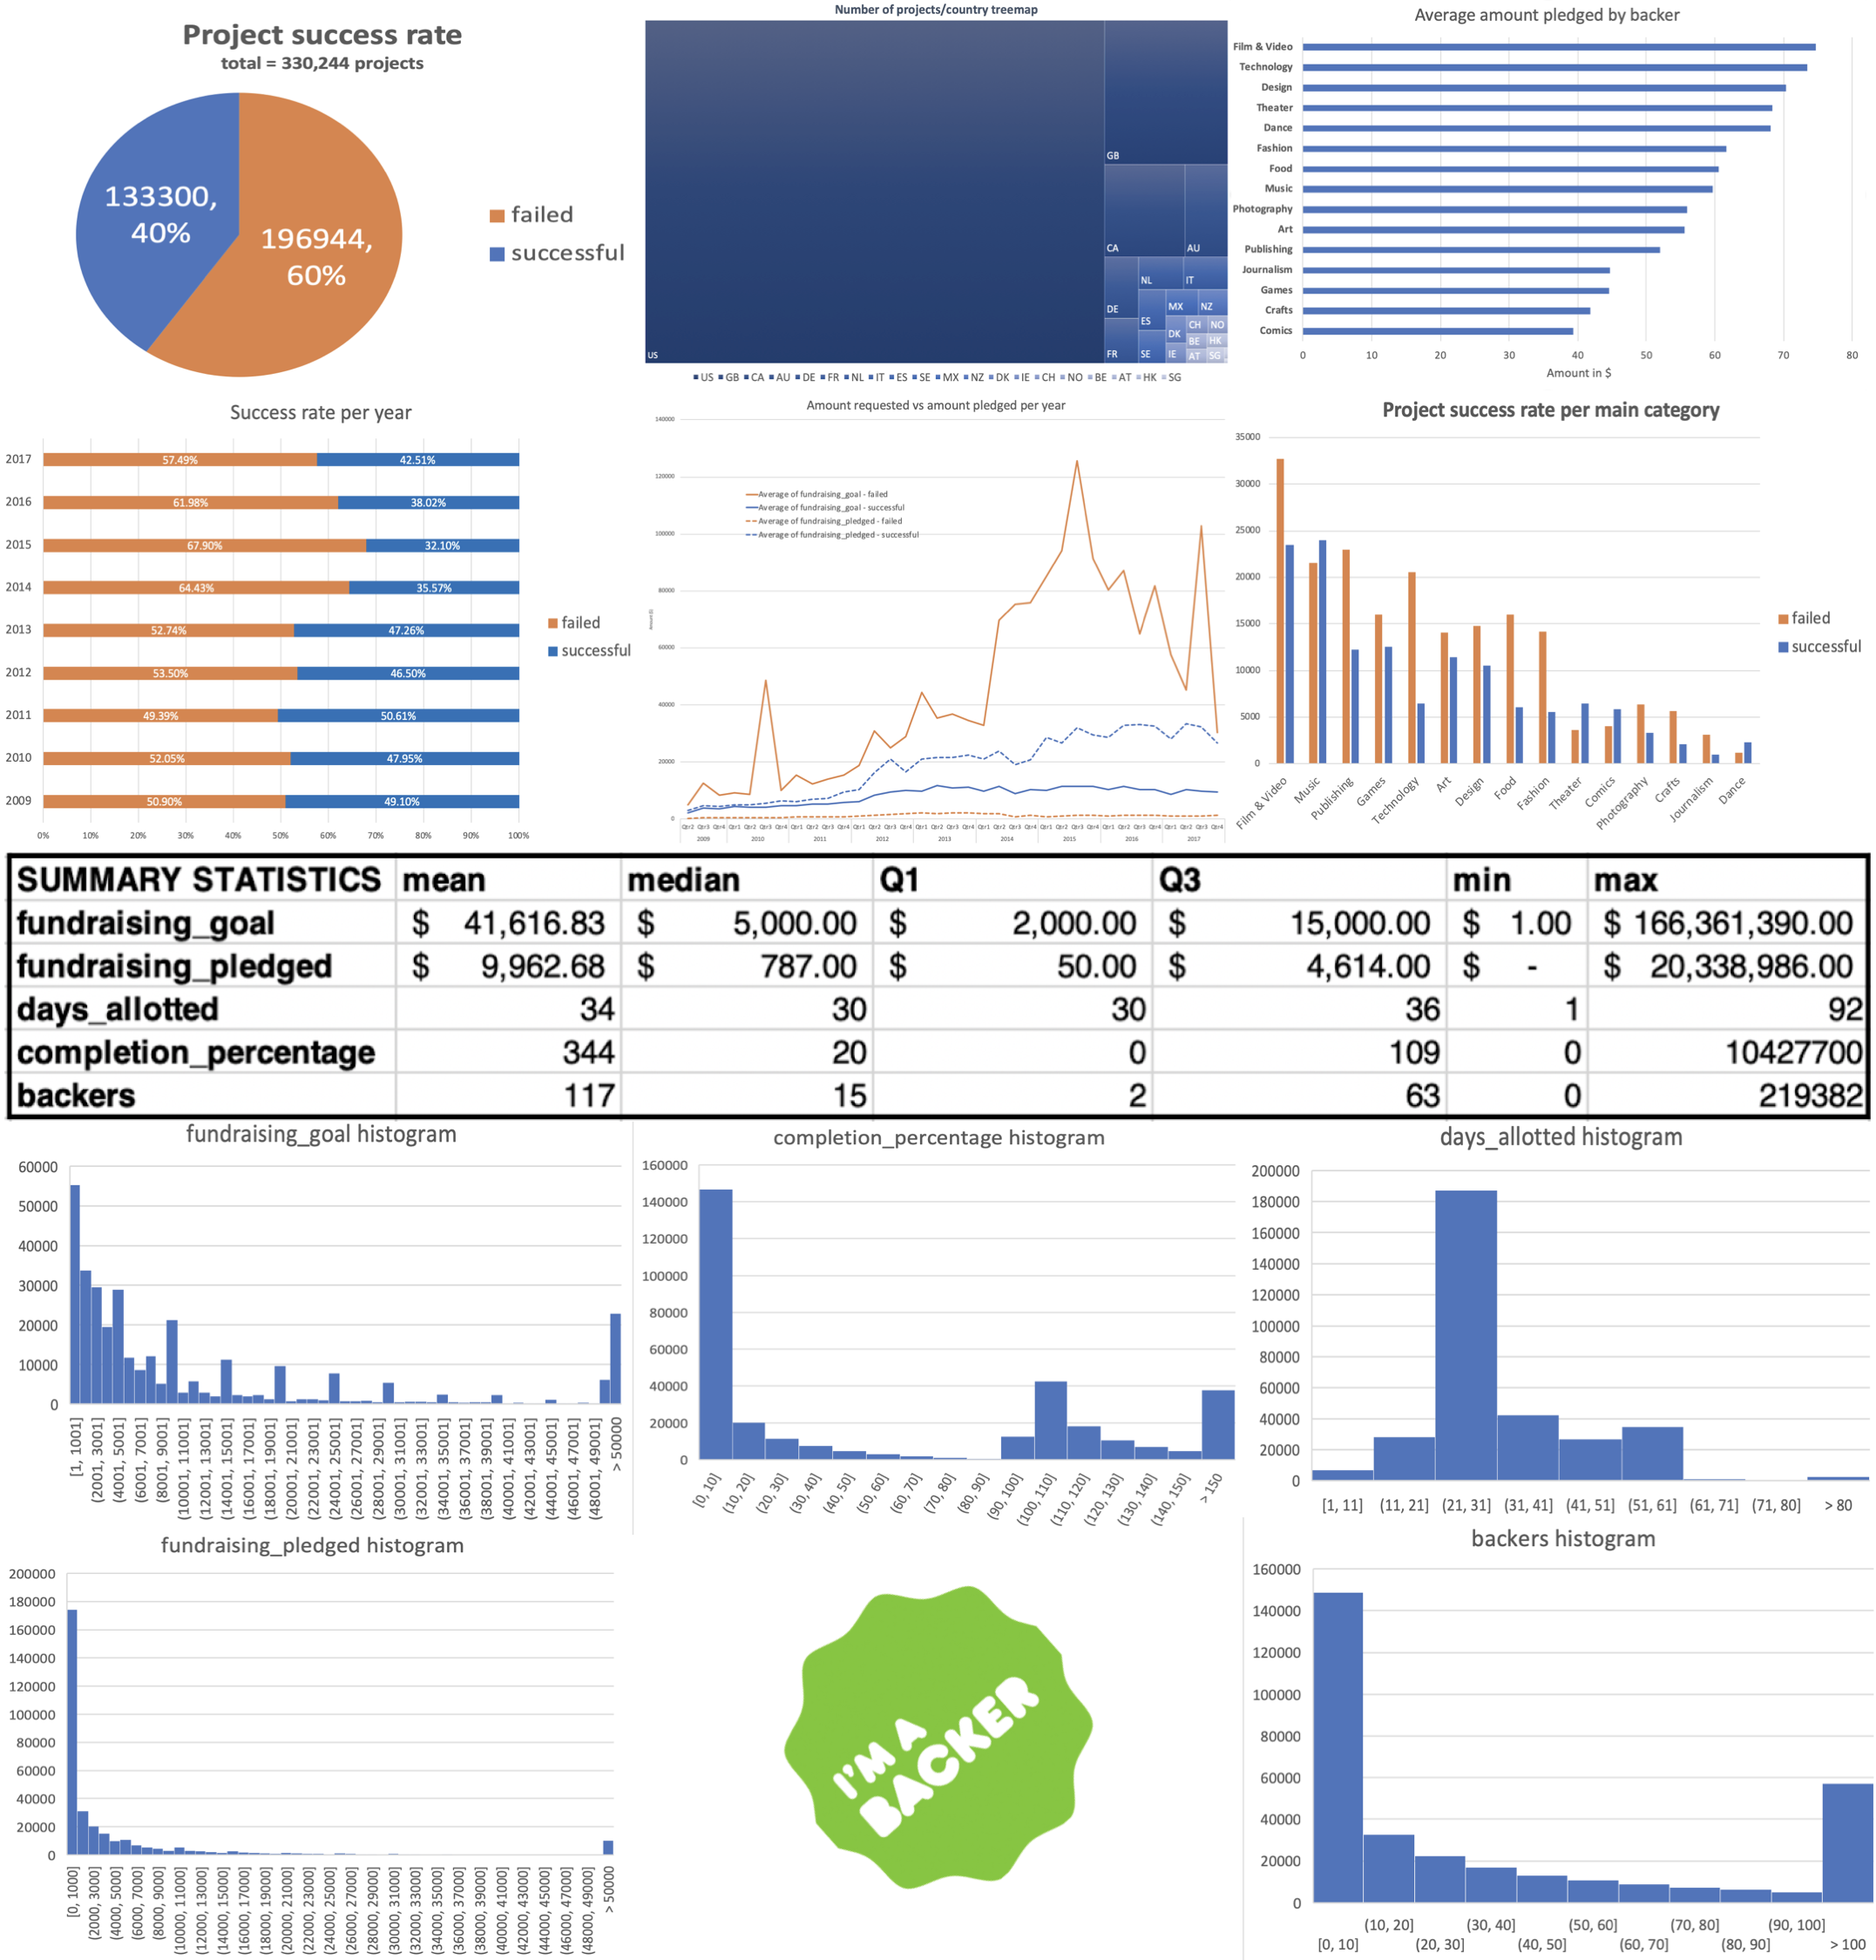

In [ ]:
# Please see presentation for more information

# III. Predictive modeling

In [23]:
# to preview the data
kickstarter_df.limit(5).toPandas()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.00,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00


## i. FEATURE ENGINEERING

In [24]:
# to import relevant packages
from pyspark.sql.functions import datediff
import datetime
from pyspark.sql.functions import year, month, dayofweek,dayofmonth

# let's first convert dates into separate columns for years, months, days, and also weekday (e.g. monday, tuesday, etc.)
kickstarter_df_CLEAN = kickstarter_df_CLEAN.select('name', 
                                                   'category', 
                                                   'main_category', 
                                                   'currency', 
                                                   'country', 
                                                   'status', 
                                                   'launched_date',
                                                   (year(fn.col('launched_date')).alias('launch_year')),
                                                   (month(fn.col('launched_date')).alias('launch_month')),
                                                   (dayofmonth(fn.col('launched_date')).alias('launch_day')),
                                                   (dayofweek(fn.col('launched_date')).alias('launch_weekday')),
                                                   'deadline',
                                                   (datediff(fn.col('deadline'), fn.col('launched_date'))).alias("days_allotted"),
                                                   'fundraising_goal', 
                                                   'fundraising_pledged', 
                                                   (((fn.col('fundraising_pledged')/fn.col('fundraising_goal'))*100).cast("int")).alias("completion_percentage"),
                                                   'backers')


In [25]:
# to preview the data
kickstarter_df_CLEAN.limit(5).toPandas()

,name,category,main_category,currency,country,status,launched_date,launch_year,launch_month,launch_day,launch_weekday,deadline,days_allotted,fundraising_goal,fundraising_pledged,completion_percentage,backers
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,GB,failed,2015-08-11,2015,8,11,3,2015-10-09,59,1533,0,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,US,failed,2017-09-02,2017,9,2,7,2017-11-01,60,30000,2421,8,15
2,Where is Hank?,Narrative Film,Film & Video,USD,US,failed,2013-01-12,2013,1,12,7,2013-02-26,45,45000,220,0,3
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,US,failed,2012-03-17,2012,3,17,7,2012-04-16,30,5000,1,0,1
4,Monarch Espresso Bar,Restaurants,Food,USD,US,successful,2016-02-26,2016,2,26,6,2016-04-01,35,50000,52375,104,224


In [26]:
# to define a function to do feature enginerring for machine learning
def feature_enginerring(dataframe):
    dataframe = dataframe.select(fn.when(fn.col('status')=='successful', 1).otherwise(0).alias('status'),
                                 'name',
                                 fn.when(fn.col('main_category')=='Food', 1).otherwise(0).alias('main_category_Food'),
                                 fn.when(fn.col('main_category')=='Art', 1).otherwise(0).alias('main_category_Art'),
                                 fn.when(fn.col('main_category')=='Fashion', 1).otherwise(0).alias('main_category_Fahion'),
                                 fn.when(fn.col('main_category')=='Publishing', 1).otherwise(0).alias('main_category_Publishing'),
                                 fn.when(fn.col('main_category')=='Crafts', 1).otherwise(0).alias('main_category_Crafts'),
                                 fn.when(fn.col('main_category')=='Comics', 1).otherwise(0).alias('main_category_Comics'),
                                 fn.when(fn.col('main_category')=='Games', 1).otherwise(0).alias('main_category_Games'),
                                 fn.when(fn.col('main_category')=='Music', 1).otherwise(0).alias('main_category_Music'),
                                 fn.when(fn.col('main_category')=='Design', 1).otherwise(0).alias('main_category_Design'),
                                 fn.when(fn.col('main_category')=='Photography', 1).otherwise(0).alias('main_category_Photography'),
                                 fn.when(fn.col('main_category')=='Technology', 1).otherwise(0).alias('main_category_Technology'),
                                 fn.when(fn.col('main_category')=='Journalism', 1).otherwise(0).alias('main_category_Journalism'),
                                 fn.when(fn.col('main_category')=='Theater', 1).otherwise(0).alias('main_category_Theater'),
                                 fn.when(fn.col('main_category')=='Dance', 1).otherwise(0).alias('main_category_Dance'),
                                 fn.when(fn.col('country')=='NL', 1).otherwise(0).alias('country_NL'),
                                 fn.when(fn.col('country')=='MX', 1).otherwise(0).alias('country_MX'),
                                 fn.when(fn.col('country')=='AT', 1).otherwise(0).alias('country_AT'),
                                 fn.when(fn.col('country')=='HK', 1).otherwise(0).alias('country_HK'),
                                 fn.when(fn.col('country')=='AU', 1).otherwise(0).alias('country_AU'),
                                 fn.when(fn.col('country')=='CA', 1).otherwise(0).alias('country_CA'),
                                 fn.when(fn.col('country')=='GB', 1).otherwise(0).alias('country_GB'),
                                 fn.when(fn.col('country')=='DE', 1).otherwise(0).alias('country_DE'),
                                 fn.when(fn.col('country')=='ES', 1).otherwise(0).alias('country_ES'),
                                 fn.when(fn.col('country')=='FR', 1).otherwise(0).alias('country_FR'),
                                 fn.when(fn.col('country')=='CH', 1).otherwise(0).alias('country_CH'),
                                 fn.when(fn.col('country')=='SG', 1).otherwise(0).alias('country_SG'),
                                 fn.when(fn.col('country')=='IT', 1).otherwise(0).alias('country_IT'),
                                 fn.when(fn.col('country')=='SE', 1).otherwise(0).alias('country_SE'),
                                 fn.when(fn.col('country')=='JP', 1).otherwise(0).alias('country_JP'),
                                 fn.when(fn.col('country')=='NZ', 1).otherwise(0).alias('country_NZ'),
                                 fn.when(fn.col('country')=='IE', 1).otherwise(0).alias('country_IE'),
                                 fn.when(fn.col('country')=='BE', 1).otherwise(0).alias('country_BE'),
                                 fn.when(fn.col('country')=='NO', 1).otherwise(0).alias('country_NO'),
                                 fn.when(fn.col('country')=='LU', 1).otherwise(0).alias('country_LU'),
                                 fn.when(fn.col('country')=='DK', 1).otherwise(0).alias('country_DK'),
                                fn.when(fn.col('launch_month')==1, 1).otherwise(0).alias('launch_month_Jan'),
                                fn.when(fn.col('launch_month')==2, 1).otherwise(0).alias('launch_month_Feb'),
                                fn.when(fn.col('launch_month')==3, 1).otherwise(0).alias('launch_month_Mar'),
                                fn.when(fn.col('launch_month')==4, 1).otherwise(0).alias('launch_month_Apr'),
                                fn.when(fn.col('launch_month')==5, 1).otherwise(0).alias('launch_month_May'),
                                fn.when(fn.col('launch_month')==7, 1).otherwise(0).alias('launch_month_Jul'),
                                fn.when(fn.col('launch_month')==8, 1).otherwise(0).alias('launch_month_Aug'),
                                fn.when(fn.col('launch_month')==9, 1).otherwise(0).alias('launch_month_Sep'),
                                fn.when(fn.col('launch_month')==10, 1).otherwise(0).alias('launch_month_Oct'),
                                fn.when(fn.col('launch_month')==11, 1).otherwise(0).alias('launch_month_Nov'),
                                fn.when(fn.col('launch_month')==12, 1).otherwise(0).alias('launch_month_Dec'),     
                                fn.when(fn.col('launch_day')<10, 1).otherwise(0).alias('launch_day_monthStart'),
                                fn.when(fn.col('launch_day')>=20, 1).otherwise(0).alias('launch_day_monthEnd'),
                                fn.when(fn.col('launch_weekday')==2, 1).otherwise(0).alias('launch_weekday_tue'),
                                fn.when(fn.col('launch_weekday')==3, 1).otherwise(0).alias('launch_weekday_wed'),
                                fn.when(fn.col('launch_weekday')==4, 1).otherwise(0).alias('launch_weekday_thu'),
                                fn.when(fn.col('launch_weekday')==5, 1).otherwise(0).alias('launch_weekday_fri'),
                                fn.when(fn.col('launch_weekday')==6, 1).otherwise(0).alias('launch_weekday_sat'),
                                fn.when(fn.col('launch_weekday')==7, 1).otherwise(0).alias('launch_weekday_sun'),
                                'days_allotted',
                                fn.log('fundraising_goal').alias('log_fundraising_goal'))
    return dataframe
    

In [27]:
# to perform feature enginerring on the data
dummy_df = feature_enginerring(kickstarter_df_CLEAN)

### NOTES
- For main_category, Film & Video will be the baseline
- For country, US will be the baseline
- For launch_month, 6 (June) will be the baseline
- For launch_day, we discretized into three bins: monthStart (X<10), monthMiddle (10<=X<20), monthEnd (X>=20) --> monthMiddle will be the baseline
- For launch_weekday, monday will be the baseline
- days_allotted is kept as is
- the log of fundraising_goal is taken (we also tried not taking the log, the accuracy is indeed a few decimals higher with taking the log)

In [28]:
# to change settings in pandas to display all columns
pd.set_option('display.max_columns', 100)

# to preview the new data (after the feature engineering)
dummy_df.limit(5).toPandas()

,status,name,main_category_Food,main_category_Art,main_category_Fahion,main_category_Publishing,main_category_Crafts,main_category_Comics,main_category_Games,main_category_Music,main_category_Design,main_category_Photography,main_category_Technology,main_category_Journalism,main_category_Theater,main_category_Dance,country_NL,country_MX,country_AT,country_HK,country_AU,country_CA,country_GB,country_DE,country_ES,country_FR,country_CH,country_SG,country_IT,country_SE,country_JP,country_NZ,country_IE,country_BE,country_NO,country_LU,country_DK,launch_month_Jan,launch_month_Feb,launch_month_Mar,launch_month_Apr,launch_month_May,launch_month_Jul,launch_month_Aug,launch_month_Sep,launch_month_Oct,launch_month_Nov,launch_month_Dec,launch_day_monthStart,launch_day_monthEnd,launch_weekday_tue,launch_weekday_wed,launch_weekday_thu,launch_weekday_fri,launch_weekday_sat,launch_weekday_sun,days_allotted,log_fundraising_goal
0,0,The Songs of Adelaide & Abullah,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,59,7.334982
1,0,Greeting From Earth: ZGAC Arts Capsule For ET,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,60,10.308953
2,0,Where is Hank?,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,45,10.714418
3,0,ToshiCapital Rekordz Needs Help to Complete Album,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30,8.517193
4,1,Monarch Espresso Bar,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,35,10.819778


In [29]:
# to check that it is correct and compare it to the orignal dataset
kickstarter_df_CLEAN.limit(2).toPandas()

,name,category,main_category,currency,country,status,launched_date,launch_year,launch_month,launch_day,launch_weekday,deadline,days_allotted,fundraising_goal,fundraising_pledged,completion_percentage,backers
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,GB,failed,2015-08-11,2015,8,11,3,2015-10-09,59,1533,0,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,US,failed,2017-09-02,2017,9,2,7,2017-11-01,60,30000,2421,8,15


## ii. DATA SPLIT

In [30]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0) # a random seed is provided in case anyone wishes to run our code and compare results

In [31]:
# to view number of columns
columns = len(dummy_df.columns)
print('number of columns in all datsets:', columns)

# to view number of rows
rows = dummy_df.count()
print('\nnumber of rows in dummy_df:', rows)

# to view number of rows
rows = training_df.count()
print('\nnumber of rows in training_df:', rows)

# to view number of rows
rows = validation_df.count()
print('number of rows in validation_df:', rows)

# to view number of rows
rows = testing_df.count()
print('number of rows in testing_df:', rows)

number of columns in all datsets: 58

number of rows in dummy_df: 330244

number of rows in training_df: 198031
number of rows in validation_df: 98999
number of rows in testing_df: 33214


In [32]:
# to display colum names for pipeline creation below
##print(dummy_df.columns)

## iii. FIRST ROUND OF MODELS (without text features)

In [36]:
# to import relevant packages

import pyspark
from pyspark.ml import feature, regression, Pipeline, classification, pipeline, evaluation
from pyspark.sql import functions as fn, Row
from pyspark import sql

from pyspark.ml.feature import MaxAbsScaler
from pyspark.ml.feature import MinMaxScaler

In [37]:
# to add all column names (minus status) to a list which will be used for the va below
cols = list(dummy_df.columns)
cols = cols[2:] # to remove status and name (we won't need name for the models in the first round)
##print(cols) # to double check

# to define a VectorAssembler
va = feature.VectorAssembler(inputCols=cols, outputCol='features_unscaled')
scaler = MinMaxScaler(inputCol="features_unscaled", outputCol="features") # to define a MinMax scaler

In [38]:
# to define an evaluator object to compute the area under the curve (AUC) of predictors
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='status')

## a. Logistic Regression 

In [39]:
# to import relevant packages
from pyspark.ml.classification import LogisticRegression

In [40]:
%%time

# to train the model
    # Model 1
lambda_par = 0  # to change regularization parameter
alpha_par = 0  # to change elastic net mixture
lr1 = LogisticRegression().setFeaturesCol('features').setLabelCol('status').setRegParam(lambda_par).setElasticNetParam(alpha_par)
# to create the pipeline
pipe1 = Pipeline(stages=[va, scaler, lr1])
# to assign the fit pipeline transformer to a new pipeline
lr_pipeline1 = pipe1.fit(training_df)

    # Model 2
lambda_par = 0.02  # to change regularization parameter
alpha_par = 0.2  # to change elastic net mixture
lr2 = LogisticRegression().setFeaturesCol('features').setLabelCol('status').setRegParam(lambda_par).setElasticNetParam(alpha_par)
# to create the pipeline
pipe2 = Pipeline(stages=[va, scaler, lr2])
# to assign the fit pipeline transformer to a new pipeline
lr_pipeline2 = pipe2.fit(training_df)

    # Model 3
lambda_par = 0.1  # to change regularization parameter
alpha_par = 0.4  # to change elastic net mixture
lr3 = LogisticRegression().setFeaturesCol('features').setLabelCol('status').setRegParam(lambda_par).setElasticNetParam(alpha_par)
# to create the pipeline
pipe3 = Pipeline(stages=[va, scaler, lr3])
# to assign the fit pipeline transformer to a new pipeline
lr_pipeline3 = pipe3.fit(training_df)


CPU times: user 120 ms, sys: 20 ms, total: 140 ms
Wall time: 2min 14s


In [41]:
# to double check that the features have been dealt with properly (e.g. using the first pipelines as an example)
pd.set_option('display.max_colwidth', -1) # to adjust column width in panads
lr_pipeline1.transform(training_df).select('features_unscaled', 'features').limit(50).toPandas()


,features_unscaled,features
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 46.0, 8.51719319142)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.494505494505, 0.449938737914]"
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 45.0, 8.41183267576)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.483516483516, 0.444372845914]"
2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 60.0, 8.16051824748)","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.648351648352, 0.431096629896]"
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 8.69951474821)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.648351648352, 0.459570259627]"
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 90.0, 6.30991827823)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.978021978022, 0.333334773867]"
5,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 91.0, 6.21460809842)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.989010989011, 0.328299812108]"
6,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 33.0, 9.51044496443)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [42]:
%%time

# to find the AUC value for our three models on the validation data
    # Model 1
AUC1_lr = evaluator.evaluate(lr_pipeline1.transform(validation_df))
print("Model 1 AUC:", AUC1_lr)
    # Model 2
AUC2_lr = evaluator.evaluate(lr_pipeline2.transform(validation_df))
print("Model 2 AUC:", AUC2_lr)
    # Model 3
AUC3_lr = evaluator.evaluate(lr_pipeline3.transform(validation_df))
print("Model 3 AUC:", AUC3_lr)


Model 1 AUC: 0.6840161263492034
Model 2 AUC: 0.6814524862259395
Model 3 AUC: 0.6366772779718802
CPU times: user 50 ms, sys: 40 ms, total: 90 ms
Wall time: 51.3 s


In [ ]:
# to assign the pipeline with the best model (i.e. model 1, which shows highest AUC) to the variable best_model
best_model_lr = lr_pipeline1

In [43]:
%%time

# to compute generalization performance on testing_data using best pipeline selected before

# to compute the generalization performance using AUC and assign it to AUC_best
AUC_best_lr = evaluator.evaluate(best_model_lr.transform(testing_df))

# to check
print("generalization performance:", AUC_best_lr)

generalization performance: 0.6850447105617062
CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 14.2 s


In [44]:
# to extract coefficients from the model
coefficients = best_model_lr.stages[-1].coefficients
coefficients = list(coefficients)

# to check that both coefficients and titles are of the same length (there should be 56)
print(len(coefficients))
print(len(cols)) # these were defined earlier

# to show the coefficients
weights = pd.DataFrame(list(zip(cols, coefficients)))
weights.columns = ['feature', 'coefficient']
weights = weights.sort_values('coefficient', ascending=False)
display(weights) # to see weights

56
56


,feature,coefficient
13,main_category_Dance,0.780135
12,main_category_Theater,0.731814
5,main_category_Comics,0.539670
17,country_HK,0.383151
7,main_category_Music,0.299580
49,launch_weekday_wed,0.157002
43,launch_month_Oct,0.087040
48,launch_weekday_tue,0.072437
6,main_category_Games,0.067138
37,launch_month_Mar,0.060058


In [45]:
# to export to csv
## weights.to_csv('featureimportanceLR.csv')

In [46]:
# number of rows in testing_df: 33214

## b. Random Forest

In [48]:
# to import relevant packages
from pyspark.ml.classification import RandomForestClassifier

In [49]:
%%time

# to train the model

# Model 1
rf1 = RandomForestClassifier(maxDepth=1, numTrees=60).setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_rf1 = Pipeline(stages=[va, rf1]).fit(training_df)

# Model 2
rf2 = RandomForestClassifier(maxDepth=6, numTrees=100).setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_rf2 = Pipeline(stages=[va, rf2]).fit(training_df)

# Model 3
rf3 = RandomForestClassifier(maxDepth=6, numTrees=80).setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_rf3 = Pipeline(stages=[va, rf3]).fit(training_df)

# Model 4
rf4 = RandomForestClassifier(maxDepth=15, numTrees=80).setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_rf4 = Pipeline(stages=[va, rf4]).fit(training_df)


# Models we tried but decided to exclude from the analysis
# We stopped at the last model, as run time was becoming too high.

# Model X
##rfX = RandomForestClassifier(maxDepth=3, numTrees=40).setFeaturesCol('features_unscaled').setLabelCol('status')
##pipe_rfX = Pipeline(stages=[va, rfX]).fit(training_df)

# Model X
##rfX = RandomForestClassifier(maxDepth=6, numTrees=20).setFeaturesCol('features_unscaled').setLabelCol('status')
##pipe_rfX = Pipeline(stages=[va, rfX]).fit(training_df)

# Model X
##rfX = RandomForestClassifier(maxDepth=8, numTrees=80).setFeaturesCol('features_unscaled').setLabelCol('status')
##pipe_rfX = Pipeline(stages=[va, rfX]).fit(training_df)

CPU times: user 240 ms, sys: 40 ms, total: 280 ms
Wall time: 7min 53s


In [50]:
%%time

# to find the AUC value for our three models on the validation data
    # Model 1
AUC1_rf = evaluator.evaluate(pipe_rf1.transform(validation_df))
print("Model 1 AUC:", AUC1_rf)
    # Model 2
AUC2_rf = evaluator.evaluate(pipe_rf2.transform(validation_df))
print("Model 2 AUC:", AUC2_rf)
    # Model 3
AUC3_rf = evaluator.evaluate(pipe_rf3.transform(validation_df))
print("Model 3 AUC:", AUC3_rf)
    # Model 4
AUC4_rf = evaluator.evaluate(pipe_rf4.transform(validation_df))
print("Model 4 AUC:", AUC4_rf)


Model 1 AUC: 0.6549820493494425
Model 2 AUC: 0.6794250670599843
Model 3 AUC: 0.6793764364091317
Model 4 AUC: 0.7003029924250679
CPU times: user 80 ms, sys: 10 ms, total: 90 ms
Wall time: 56.4 s


In [51]:
# to assign the pipeline with the best model (i.e. model 3, which shows highest AUC) to the variable best_model
best_model_rf = pipe_rf4

In [52]:
%%time

# to compute generalization performance on testing_data using best pipeline selected before

# to compute the generalization performance using AUC and assign it to AUC_best
AUC_best_rf = evaluator.evaluate(best_model_rf.transform(testing_df))

# to check
print("generalization performance of best model:", AUC_best_rf)

generalization performance of best model: 0.7024998738691467
CPU times: user 10 ms, sys: 10 ms, total: 20 ms
Wall time: 16.1 s


In [53]:
# to find tp, tn, fp, fn
tpos = best_model_rf.transform(testing_df).filter("status=1").filter("prediction=1").count()
tneg = best_model_rf.transform(testing_df).filter("status=0").filter("prediction=0").count()
fpos = best_model_rf.transform(testing_df).filter("status=0").filter("prediction=1").count()
fneg = best_model_rf.transform(testing_df).filter("status=1").filter("prediction=0").count()

# to compute a confusion matrix of the testing_data data
d = {'pred 0': [tneg, fneg], 'pred 1': [fpos, tpos]}
df = pd.DataFrame(data=d)
df = df.rename(index={0: 'actual 0', 1: 'actual 1'})
print("CONFUSION MATRIX:")
display(df)

CONFUSION MATRIX:


,pred 0,pred 1
actual 0,16950,2850
actual 1,8504,4910


In [54]:
# precision
precision = tpos/(tpos+fpos)
print("precision:", round(precision, 2))

# recall
recall = tpos/(tpos+fneg)
print("recall", round(recall, 2))

precision: 0.63
recall 0.37


In [55]:
# to look at the importance of features

# to extract the classifier
rf_model = best_model_rf.stages[-1]

# to create the datafraem
feature_importance = pd.DataFrame(list(zip(cols, rf_model.featureImportances.toArray())),
                                  columns = ['feature', 'importance']).sort_values('importance', ascending=False)
# to view
feature_importance

,feature,importance
55,log_fundraising_goal,0.349253
54,days_allotted,0.197976
7,main_category_Music,0.053358
10,main_category_Technology,0.048874
12,main_category_Theater,0.042251
2,main_category_Fahion,0.030589
5,main_category_Comics,0.026863
0,main_category_Food,0.023740
4,main_category_Crafts,0.015859
3,main_category_Publishing,0.012859


In [56]:
# to export to csv
##feature_importance.to_csv('featureimportanceRF.csv')

In [57]:
# let's see how many trees we created (should be 20)
len(rf_model.trees)

80

In [58]:
# let's randomly pick one of the trees we created (tree #0 for example)
example_tree = rf_model.trees[0].toDebugString

# to print the tree
print(example_tree)

DecisionTreeClassificationModel (uid=dtc_7b84a5456f1c) of depth 15 with 4091 nodes
  If (feature 54 <= 29.5)
   If (feature 55 <= 8.853736851507325)
    If (feature 2 <= 0.5)
     If (feature 19 <= 0.5)
      If (feature 10 <= 0.5)
       If (feature 55 <= 7.783432306278645)
        If (feature 0 <= 0.5)
         If (feature 12 <= 0.5)
          If (feature 5 <= 0.5)
           If (feature 14 <= 0.5)
            If (feature 6 <= 0.5)
             If (feature 40 <= 0.5)
              If (feature 11 <= 0.5)
               If (feature 4 <= 0.5)
                If (feature 9 <= 0.5)
                 Predict: 1.0
                Else (feature 9 > 0.5)
                 Predict: 1.0
               Else (feature 4 > 0.5)
                If (feature 34 <= 0.5)
                 Predict: 0.0
                Else (feature 34 > 0.5)
                 Predict: 0.0
              Else (feature 11 > 0.5)
               If (feature 54 <= 24.5)
                If (feature 53 <= 0.5)
                 Predi

In [59]:
# to test the model and output a predict

# ENTER VARIABLES HERE
# name
X0 = 'name' # this variable will not actually be considered in round #1
# main_category
X1 = 'Dance'
# country
X2 = 'US'
# launch_month 
X3 = 2
# launch_day 
X4 = 25
# launch_weekday 
X5 = 6
# days_allotted 
X6 = 30
# fundraising_goal 
X7 = 1000

# to create a dataset from values above
raw_data = [Row(status = 'failed', name = X0, main_category = X1, country = X2, launch_month = X3, launch_day = X4, launch_weekday = X5, days_allotted = X6, fundraising_goal = X7)]
dataForTest = spark.createDataFrame(raw_data) # to create a spark dataframe
dataForTest = feature_enginerring(dataForTest) # to perform feature engineering on that dataset with a single row

# to check that the feature engineering was done properly
##dataForTest.limit(1).toPandas()

# to see the prediction
best_model_rf.transform(dataForTest).select('prediction').toPandas()
#best_model_rf.transform(dataForTest).select('*').first()


,prediction
0,1.0


## c. Naive Bayes

In [60]:
# to import relevant packages
from pyspark.ml.classification import NaiveBayes

In [61]:
%%time

# to train the model

    # Model 1 (unscaled)
nb1 = NaiveBayes(smoothing=1.0, modelType='multinomial').setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_nb1 = Pipeline(stages=[va, nb1]).fit(training_df)
    # Model 2 (unscaled)
nb2 = NaiveBayes(smoothing=5.0, modelType='multinomial').setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_nb2 = Pipeline(stages=[va, nb2]).fit(training_df)
    # Model 3 (scaled)
nb3 = NaiveBayes(smoothing=1.0, modelType='multinomial').setFeaturesCol('features').setLabelCol('status')
pipe_nb3 = Pipeline(stages=[va, scaler, nb3]).fit(training_df)

CPU times: user 70 ms, sys: 20 ms, total: 90 ms
Wall time: 1min 34s


In [62]:
%%time

# to find the AUC value for our three models on the validation data
    # Model 1 (unscaled)
AUC1_nb = evaluator.evaluate(pipe_nb1.transform(validation_df))
print("Model 1 AUC:", AUC1_nb)
    # Model 2 (unscaled)
AUC2_nb = evaluator.evaluate(pipe_nb2.transform(validation_df))
print("Model 2 AUC:", AUC2_nb)
    # Model 3 (scaled)
AUC3_nb = evaluator.evaluate(pipe_nb3.transform(validation_df))
print("Model 3 AUC:", AUC3_nb)


Model 1 AUC: 0.6085235587587879
Model 2 AUC: 0.6085233060209709
Model 3 AUC: 0.556468367643826
CPU times: user 50 ms, sys: 10 ms, total: 60 ms
Wall time: 49.6 s


In [63]:
# to assign the pipeline with the best model (i.e. model 3, which shows highest AUC) to the variable best_model
best_model_nb = pipe_nb2

# Note that smoothing does not make a difference. Also, the performance is higher with unscaled data.

In [64]:
%%time

# to compute generalization performance on testing_data using best pipeline selected before

# to compute the generalization performance using AUC and assign it to AUC_best
AUC_best_nb = evaluator.evaluate(best_model_nb.transform(testing_df))

# to check
print("generalization performance of best model:", AUC_best_nb)

generalization performance of best model: 0.6124211362167917
CPU times: user 10 ms, sys: 10 ms, total: 20 ms
Wall time: 11.9 s


## iv. SECOND ROUND OF MODELS (with text features)

In [57]:
# create a Pipeline transformer and name it tfidf_pipeline


# to import relevant packages
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import StopWordsRemover

# to import stop words (from the tm package in R -- the list of stopwords is very good as it only contains grammatical words)
stop_words = ["i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself","yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself","they","them","their","theirs","themselves","what","which","who","whom","this","that","these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did","doing","would","should","could","ought","i'm","you're","he's","she's","it's","we're","they're","i've","you've","we've","they've","i'd","you'd","he'd","she'd","we'd","they'd","i'll","you'll","he'll","she'll","we'll","they]ll","isn't","aren't","wasn't","weren't","hasn't","haven't","hadn't","doesn't","don't","didn't","won't","wouldn't","shan't","shouldn't","can't","cannot","couldn't","mustn't","let's","that's","who's","what's","here's","there's","when's","where's","why's","how's","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about","against","between","into","through","during","before","after","above","below","to","from","up","down","in","out","on","off","over","under","again","further","then","once","here","there","when","where","why","how","all","any","both","each","few","more","most","other","some","such","no","nor","not","only","own","same","so","than","too","very"]
##print(stop_words) # to check

# to create cols2 that contains the latest tfidf features
cols2 = cols + ['tfidf']

# to define our 3 estimators
##tokenizer = Tokenizer().setInputCol('name').setOutputCol('words') # this converts to lowercase and splits into tokens
tokenizer = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("name").setOutputCol("words") # this regex tokenizer lowercases the data, removes punctuation, and splits the words into tokens
sw_filter = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("words").setOutputCol("filtered")
count_vectorizer = CountVectorizer().setInputCol('filtered').setOutputCol('tf')
idf = IDF().setInputCol('tf').setOutputCol('tfidf')
va2 = feature.VectorAssembler(inputCols=cols2, outputCol='features_unscaled')
##scaler = MinMaxScaler(inputCol="features_unscaled", outputCol="features") # to define a MinMax scaler (this was already done previously in the code)



# to create the pipeline transformer
##tfidf_pipeline = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf]).fit(training_df)

# to make the transformation from the raw text to tfidf and show the first 10 results
##tfidf_pipeline.transform(training_df).limit(10).toPandas()

## a. Logistic Regression 

In [58]:
%%time

# to train the model
    # Model 1
lambda_par = 0  # to change regularization parameter
alpha_par = 0  # to change elastic net mixture
lr1_TF = LogisticRegression().setFeaturesCol('features').setLabelCol('status').setRegParam(lambda_par).setElasticNetParam(alpha_par)
# to create the pipeline
pipe1_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, scaler, lr1_TF])
# to assign the fit pipeline transformer to a new pipeline
lr_pipeline1_TF = pipe1_TF.fit(training_df)
'''
    # Model 2
lambda_par = 0.02  # to change regularization parameter
alpha_par = 0.2  # to change elastic net mixture
lr2_TF = LogisticRegression().setFeaturesCol('features').setLabelCol('status').setRegParam(lambda_par).setElasticNetParam(alpha_par)
# to create the pipeline
pipe2_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, scaler, lr2_TF])
# to assign the fit pipeline transformer to a new pipeline
lr_pipeline2_TF = pipe2_TF.fit(training_df)

    # Model 3
lambda_par = 0.1  # to change regularization parameter
alpha_par = 0.4  # to change elastic net mixture
lr3_TF = LogisticRegression().setFeaturesCol('features').setLabelCol('status').setRegParam(lambda_par).setElasticNetParam(alpha_par)
# to create the pipeline
pipe3_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, scaler, lr3_TF])
# to assign the fit pipeline transformer to a new pipeline
lr_pipeline3_TF = pipe3_TF.fit(training_df)
'''


CPU times: user 1.85 s, sys: 1.24 s, total: 3.09 s
Wall time: 4h 24min 47s


In [59]:
%%time

# to find the AUC value for our three models on the validation data
    # Model 1
AUC1_lr_TF = evaluator.evaluate(lr_pipeline1_TF.transform(validation_df))
print("Model 1 AUC TF:", AUC1_lr_TF)
'''
    # Model 2
AUC2_lr_TF = evaluator.evaluate(lr_pipeline2_TF.transform(validation_df))
print("Model 2 AUC TF:", AUC2_lr_TF)
    # Model 3
AUC3_lr_TF = evaluator.evaluate(lr_pipeline3_TF.transform(validation_df))
print("Model 3 AUC TF:", AUC3_lr_TF)
'''


Model 1 AUC TF: 0.6567246315135579
CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 3min 48s


In [60]:
# to assign the pipeline with the best model (i.e. model 1, which shows highest AUC) to the variable best_model
best_model_lr_TF = lr_pipeline1_TF

In [61]:
%%time

# to compute generalization performance on testing_data using best pipeline selected before

# to compute the generalization performance using AUC and assign it to AUC_best
AUC_best_lr_TF = evaluator.evaluate(best_model_lr_TF.transform(testing_df))

# to check
print("generalization performance:", AUC_best_lr_TF)

generalization performance: 0.6545107723274207
CPU times: user 70 ms, sys: 20 ms, total: 90 ms
Wall time: 1min 30s


## b. Random Forest

**NOTE**
- RANDOM FOREST WAS DROPPED AS A CANDIDATE ALGORITHM FOR ROUND #2
- THE SERVER WOULD CRASH IN ALL OF OUR EXPERIMENTS -- IT HAD TOO MANY TEXT FEATURES

In [ ]:
%%time

# to train the model
'''
# Model 1
rf1_TF = RandomForestClassifier(maxDepth=1, numTrees=60).setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_rf1_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, rf1_TF]).fit(training_df)

# Model 2
rf2_TF = RandomForestClassifier(maxDepth=6, numTrees=100).setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_rf2_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, rf2_TF]).fit(training_df)

# Model 3
rf3_TF = RandomForestClassifier(maxDepth=6, numTrees=80).setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_rf3_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, rf3_TF]).fit(training_df)
'''

'''
# Model 4
rf4_TF = RandomForestClassifier(maxDepth=15, numTrees=80).setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_rf4_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, rf4_TF]).fit(training_df)
'''

In [ ]:
%%time

# to find the AUC value for our three models on the validation data
'''
    # Model 1
AUC1_rf_TF = evaluator.evaluate(pipe_rf1_TF.transform(validation_df))
print("Model 1 AUC TF:", AUC1_rf_TF)
    # Model 2
AUC2_rf_TF = evaluator.evaluate(pipe_rf2_TF.transform(validation_df))
print("Model 2 AUC TF:", AUC2_rf_TF)
    # Model 3
AUC3_rf_TF = evaluator.evaluate(pipe_rf3_TF.transform(validation_df))
print("Model 3 AUC TF:", AUC3_rf_TF)
'''

'''
    # Model 4
AUC4_rf_TF = evaluator.evaluate(pipe_rf4_TF.transform(validation_df))
print("Model 4 AUC TF:", AUC4_rf_TF)
'''

In [ ]:
'''
# to assign the pipeline with the best model (i.e. model 3, which shows highest AUC) to the variable best_model
best_model_rf_TF = pipe_rf4_TF
'''

In [ ]:
%%time

'''
# to compute generalization performance on testing_data using best pipeline selected before

# to compute the generalization performance using AUC and assign it to AUC_best
AUC_best_rf_TF = evaluator.evaluate(best_model_rf_TF.transform(testing_df))

# to check
print("generalization performance of best model:", AUC_best_rf_TF)
'''

## c. Naive Bayes

In [62]:
%%time

# to train the model
'''
    # Model 1 (unscaled)
nb1_TF = NaiveBayes(smoothing=1.0, modelType='multinomial').setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_nb1_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, nb1_TF]).fit(training_df)
'''
    # Model 2 (unscaled)
nb2_TF = NaiveBayes(smoothing=5.0, modelType='multinomial').setFeaturesCol('features_unscaled').setLabelCol('status')
pipe_nb2_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, nb2_TF]).fit(training_df)

'''
    # Model 3 (scaled)
nb3_TF = NaiveBayes(smoothing=1.0, modelType='multinomial').setFeaturesCol('features').setLabelCol('status')
pipe_nb3_TF = Pipeline(stages=[tokenizer, sw_filter, count_vectorizer, idf, va2, scaler, nb3_TF]).fit(training_df)
'''

CPU times: user 50 ms, sys: 20 ms, total: 70 ms
Wall time: 1min 3s


In [63]:
%%time

# to find the AUC value for our three models on the validation data
'''
    # Model 1 (unscaled)
AUC1_nb_TF = evaluator.evaluate(pipe_nb1_TF.transform(validation_df))
print("Model 1 AUC TF:", AUC1_nb_TF)
'''
    # Model 2 (unscaled)
AUC2_nb_TF = evaluator.evaluate(pipe_nb2_TF.transform(validation_df))
print("Model 2 AUC TF:", AUC2_nb_TF)
'''
    # Model 3 (scaled)
AUC3_nb_TF = evaluator.evaluate(pipe_nb3_TF.transform(validation_df))
print("Model 3 AUC TF:", AUC3_nb_TF)
'''


Model 2 AUC TF: 0.4602601338487628
CPU times: user 30 ms, sys: 50 ms, total: 80 ms
Wall time: 29.4 s


In [64]:
# to assign the pipeline with the best model (i.e. model 3, which shows highest AUC) to the variable best_model
best_model_nb_TF = pipe_nb2_TF

# Note that smoothing does not make a difference. Also, the performance is higher with unscaled data.

In [65]:
%%time

# to compute generalization performance on testing_data using best pipeline selected before

# to compute the generalization performance using AUC and assign it to AUC_best
AUC_best_nb_TF = evaluator.evaluate(best_model_nb_TF.transform(testing_df))

# to check
print("generalization performance of best model:", AUC_best_nb_TF)

generalization performance of best model: 0.4648184186429666
CPU times: user 50 ms, sys: 10 ms, total: 60 ms
Wall time: 25.4 s


# IV. Conclusion

- Performance was quite high overall with random forest (approx. 70%)
- As a result, success rate may not only depend on the data and could also greatly vary based on factors that are unavailable to us/specific to each project
- Text features did not help improve performance with these models

**FUTURE WORK**
- Rerun logistic regression on text features using elastic net regularization despite the very high computational cost, and utilize/implement more algorithms which allow for more complex learning (e.g. neural networks)
- Attempt to predict fundraising_pledged and number of backers (i.e. numeric variables with a linear relationship instead of categorical ones/classification outcomes)
- Retrieve more data/projects to improve performance

In [ ]:
# Please refer to the poster presentation for complementary interpretations and conclusions.